In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url = "https://raw.githubusercontent.com/LuisM78/Appliances-energy-prediction-data/master/energydata_complete.csv"
df = pd.read_csv(url, infer_datetime_format=True, index_col=['date'])
df.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [3]:
df = df.loc["2016-05-01":]
df.shape

(3853, 28)

In [4]:
df = df.round(2)

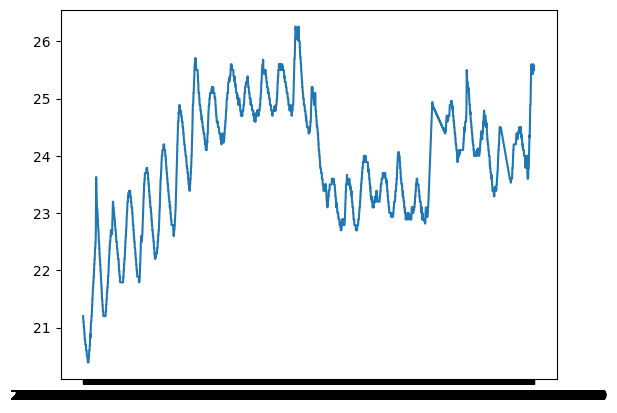

In [5]:
plt.plot(df['T1'])

In [6]:
# If I want to take 2 days data as test set
# Let's first see how many rows we have in one day
# The data we have in 10 minutes interval
# total minutes in a day 24*60
# total rows (24*60)/10
size = (24*60)//10

In [7]:
test_days = 2
test_index = size*test_days
test_index

288

In [8]:
train = df.iloc[test_index:]
test = df.iloc[:test_index]

In [9]:
train.shape, test.shape

((3565, 28), (288, 28))

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 144
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=batch_size)
val_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                length=length, batch_size=batch_size)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

"""This is the first change compared to univariate analysis"""
n_features = scaled_train.shape[1]

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length,n_features)))

"""
This is the 2nd change
Dense should have the neurons equal to the number of features
"""
model.add(Dense(n_features))

model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               51600     
                                                                 
 dense (Dense)               (None, 28)                2828      
                                                                 
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [15]:
model.fit(generator, validation_data=val_generator, epochs=10, callbacks=[early_stop])

Epoch 1/10
3421/3421 [==============================] - 142s 41ms/step - loss: 0.0141 - val_loss: 0.0125
Epoch 2/10
3421/3421 [==============================] - 208s 61ms/step - loss: 0.0087 - val_loss: 0.0098
Epoch 3/10
3421/3421 [==============================] - 190s 55ms/step - loss: 0.0080 - val_loss: 0.0101
Epoch 4/10
3421/3421 [==============================] - 195s 57ms/step - loss: 0.0077 - val_loss: 0.0093
Epoch 5/10
3421/3421 [==============================] - 168s 49ms/step - loss: 0.0075 - val_loss: 0.0088
Epoch 6/10
3421/3421 [==============================] - 162s 47ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 7/10
3421/3421 [==============================] - 171s 50ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 8/10
3421/3421 [==============================] - 158s 46ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 9/10
3421/3421 [==============================] - 170s 50ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 10/10
3421/3421 [==============================] 

<AxesSubplot:>

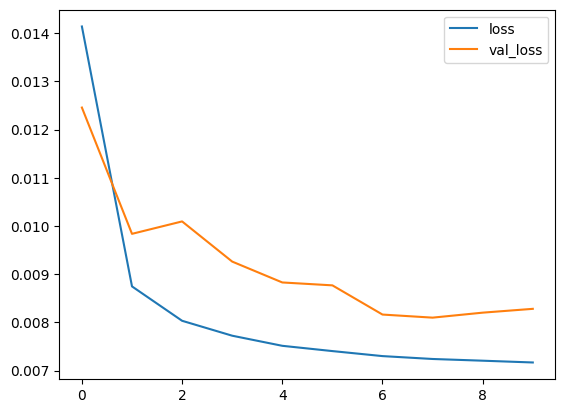

In [16]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [17]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))  

for i in range(len(test)):
    current_pred = model.predict(current_batch, verbose=0)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [23]:
true_predictions = scaler.inverse_transform(test_predictions)

In [27]:
predicted_df = pd.DataFrame(data=true_predictions, columns = test.columns)

In [29]:
predicted_df.isna().sum()

Appliances     137
lights         137
T1             137
RH_1           137
T2             137
RH_2           137
T3             137
RH_3           137
T4             137
RH_4           137
T5             137
RH_5           137
T6             137
RH_6           137
T7             137
RH_7           137
T8             137
RH_8           137
T9             137
RH_9           137
T_out          137
Press_mm_hg    137
RH_out         137
Windspeed      137
Visibility     137
Tdewpoint      137
rv1            137
rv2            137
dtype: int64

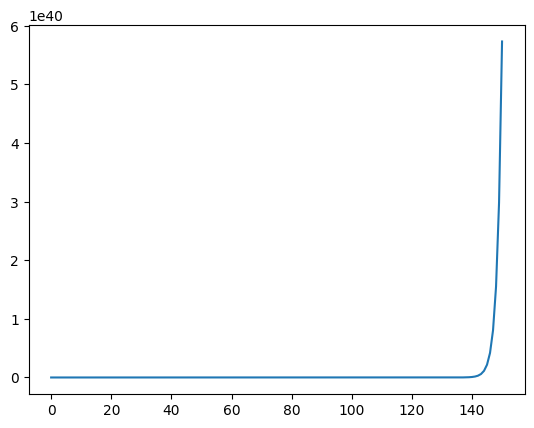

In [35]:
plt.plot(predicted_df['Appliances'])

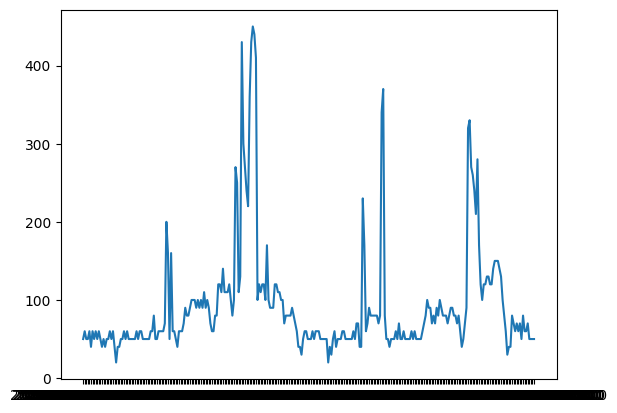

In [36]:
plt.plot(test['Appliances'])

In [39]:
test.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.20,38.20,18.39,41.4,23.20,36.40,19.73,37.73,...,19.17,38.20,4.30,763.70,86.00,2.00,40.00,2.20,15.31,15.31
2016-05-01 00:10:00,60,0,21.15,38.17,18.39,41.5,23.13,36.47,19.70,37.66,...,19.13,38.29,4.28,763.72,86.33,2.17,38.17,2.22,11.24,11.24


In [40]:
predicted_df.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,293.369376,7.688470,25.652485,48.501712,25.313933,44.724447,27.006234,41.499073,24.779679,46.491055,...,23.230670,46.649490,21.815626,755.588509,59.110701,4.403574,26.776691,13.538238,22.446232,22.283441
1,185.996156,6.608336,25.778864,49.682741,25.256323,46.219607,27.179860,42.187315,24.840705,47.423731,...,23.297609,46.626039,21.366318,756.234669,62.672028,4.697132,25.929432,13.909259,23.448488,23.361212
